In [1]:
# default_exp moe

# Merit Order Effect Analysis

<br>

### Imports

In [2]:
#exports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pickle
import FEAutils as hlp
from ipypb import track

from moepy import lowess, eda

In [3]:
%%time

df_EI = eda.load_EI_df('../data/electric_insights.csv')

df_EI.head()

Wall time: 2.08 s


,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


Text(0, 0.5, 'Price (£/MWh)')

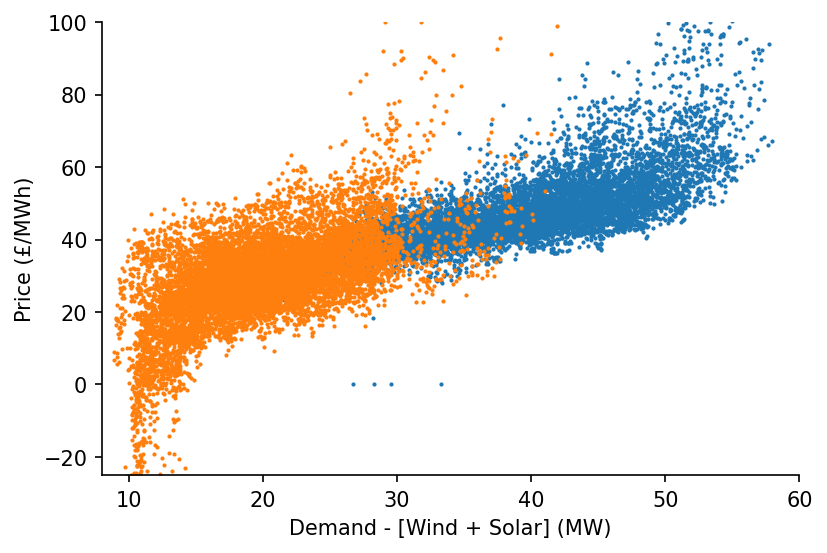

In [4]:
df_EI_model = df_EI[['day_ahead_price', 'demand', 'solar', 'wind']].dropna()

s_price = df_EI_model['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_dispatchable['2010-09':'2011-03'], s_price['2010-09':'2011-03'], s=1)
ax.scatter(s_dispatchable['2020-03':'2020-09'], s_price['2020-03':'2020-09'], s=1)

hlp.hide_spines(ax)
ax.set_xlim(8, 60)
ax.set_ylim(-25, 100)
ax.set_xlabel('Demand - [Wind + Solar] (MW)')
ax.set_ylabel('Price (£/MWh)')

In [5]:
%%time

model_fp = '../data/models/weekly_price_curve.pkl'
load_existing_model = True

if load_existing_model == True:
    smooth_dates = pickle.load(open(model_fp, 'rb'))
else:
    reg_dates = pd.date_range('2009-01-01', '2021-01-01', freq='13W')

    smooth_dates = lowess.SmoothDates()
    smooth_dates.fit(s_dispatchable.values, s_price.values, dt_idx=s_dispatchable.index, 
                     reg_dates=reg_dates, frac=0.3, num_fits=31, threshold_value=26)
    
    pickle.dump(smooth_dates, open(model_fp, 'wb'))

Wall time: 2.26 s


In [6]:
%%time

x_pred = np.linspace(8, 60, 53)
dt_pred = pd.date_range('2009-01-01', '2021-01-01', freq='1W')

df_pred = smooth_dates.predict(x_pred=x_pred, dt_pred=dt_pred)

df_pred.head()

Wall time: 205 ms


,2009-01-04,2009-01-11,2009-01-18,2009-01-25,2009-02-01,2009-02-08,2009-02-15,2009-02-22,2009-03-01,2009-03-08,...,2020-10-25,2020-11-01,2020-11-08,2020-11-15,2020-11-22,2020-11-29,2020-12-06,2020-12-13,2020-12-20,2020-12-27
8.0,-25.197904,-26.115663,-27.021418,-27.915357,-28.796883,-29.664809,-30.517526,-31.353158,-32.169685,-32.965054,...,23.572525,23.213912,22.843075,22.462054,22.072696,21.676566,21.274846,20.868216,20.456733,20.040016
9.0,-19.697833,-20.456428,-21.204316,-21.941144,-22.666083,-23.377963,-24.075394,-24.756870,-25.420858,-26.065868,...,31.917752,31.378530,30.826263,30.263563,29.692668,29.115289,28.532452,27.944308,27.349928,26.747826
10.0,-14.198458,-14.797930,-15.387991,-15.967752,-16.536150,-17.092035,-17.634235,-18.161616,-18.673129,-19.167849,...,40.276605,39.556746,38.823006,38.078569,37.326061,36.567345,35.803291,35.033520,34.256120,33.468504
11.0,-8.701850,-9.142475,-9.574992,-9.997980,-10.410151,-10.810376,-11.197705,-11.571376,-11.930827,-12.275695,...,48.716357,47.814369,46.897640,45.969934,45.034271,44.092663,43.145825,42.192849,41.230832,40.256078
12.0,-3.207986,-3.489884,-3.764980,-4.031326,-4.287412,-4.532133,-4.764760,-4.984906,-5.192493,-5.387723,...,57.211066,56.126194,55.025692,53.913908,52.794255,51.668901,50.538406,49.401328,48.253777,47.090942


<AxesSubplot:>

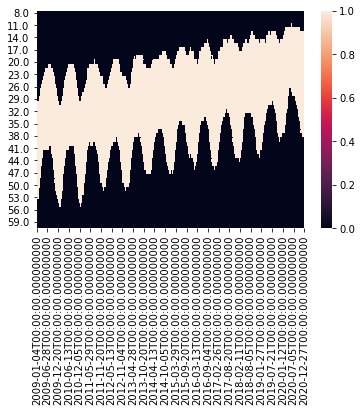

In [83]:
rolling_w = 10

df_dispatchable_lims = (s_dispatchable
                        .resample('1W')
                        .quantile([0.01, 0.99])
                        .unstack()
                        .rolling(rolling_w)
                        .mean() # would be best to take the min for 0.01 and max for 0.99
                        .shift(int(-rolling_w/2))
                        .bfill()
                        .ffill()
                        .iloc[:-1, :]
                       )

df_pred_mask = pd.DataFrame(dict(zip(df_pred.columns, [df_pred.index]*df_pred.shape[1])), index=df_pred.index)
df_pred_mask = (df_pred_mask > df_dispatchable_lims.iloc[:, 0].values) & (df_pred_mask < df_dispatchable_lims.iloc[:, 1].values)

sns.heatmap(df_pred_mask)

Text(0.5, 1.0, 'Day-Ahead Mkt Price Curve Estimate')

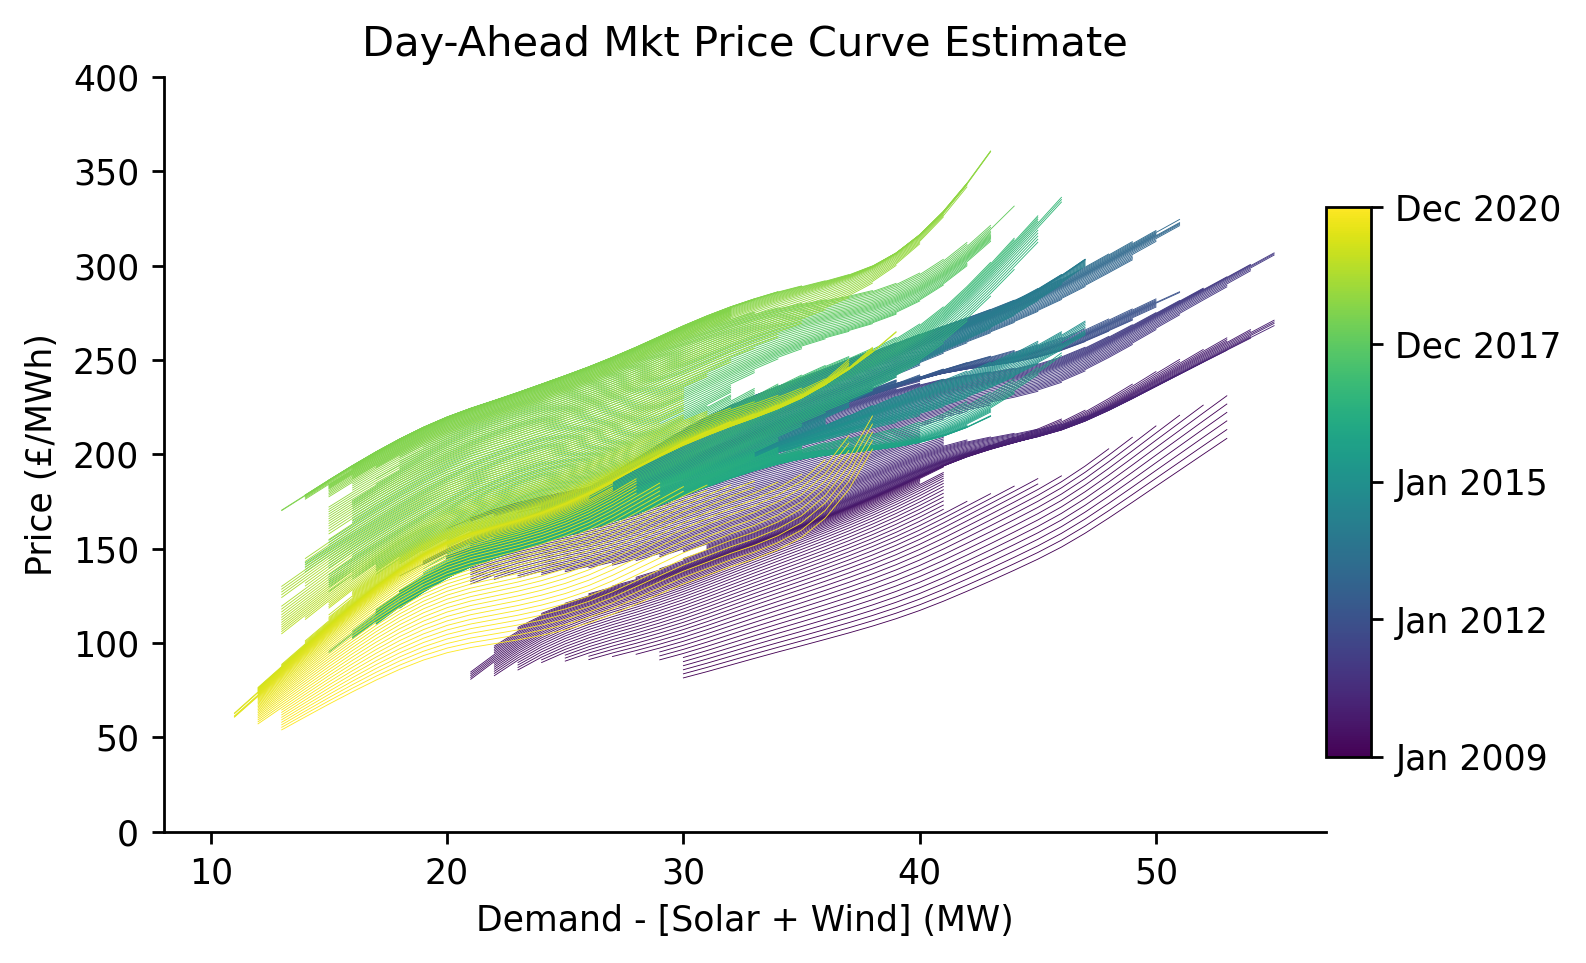

In [84]:
cmap = plt.get_cmap('viridis')
cbar_ticks = [0, 0.25, 0.5, 0.75, 1]

# Plotting
fig, ax = plt.subplots(dpi=250)

lp = df_pred.where(df_pred_mask, np.nan).plot(legend=False, cmap=cmap, linewidth=0.25, ax=ax)

cax = fig.add_axes([0.9, 0.2, 0.03, 0.55])
cbar = mpl.colorbar.ColorbarBase(cax, orientation='vertical', cmap=cmap, ticks=cbar_ticks)
cbar.ax.set_yticklabels([dt_pred[min(int(len(dt_pred)*tick_loc), len(dt_pred)-1)].strftime('%b %Y') for tick_loc in cbar_ticks])

hlp.hide_spines(ax)
ax.set_xlabel('Demand - [Solar + Wind] (MW)')
ax.set_ylabel('Price (£/MWh)')
ax.set_xlim(df_pred.index[0])
ax.set_ylim(0, 400)
ax.set_title('Day-Ahead Mkt Price Curve Estimate')

In [ ]:
# Need to work out how often values fall outside the mask when looking at the full ts
# would be cool to have a gif where each frame is the addition of a new week

In [9]:
#hide
from nbdev.export import *
notebook2script()

Converted 01-retrieval.ipynb.
Converted 02-eda.ipynb.
Converted 03-lowess.ipynb.
Converted 04-merit-order-effect.ipynb.
